In [86]:
import torch
import numpy as np
# tensorboard
from torch.utils.tensorboard import SummaryWriter
import math
writer = SummaryWriter()

In [2]:
# create a LeNet-5 by PyTorch using nn.Sequential
class LeNet5Sequential(torch.nn.Module):
    def __init__(self):
        super(LeNet5Sequential, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(1, 6, 5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),
            torch.nn.Conv2d(6, 16, 5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),
            torch.nn.Flatten(),
            torch.nn.Linear(16*5*5, 120),
            torch.nn.ReLU(),
            torch.nn.Linear(120, 84),
            torch.nn.ReLU(),
            torch.nn.Linear(84, 10),
            torch.nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        return self.model(x)

In [3]:
# load the MNIST dataset
from torchvision import datasets, transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



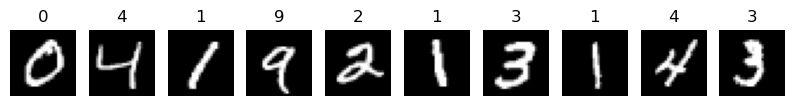

In [12]:
# plot some images from the dataset
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
for i in range(1, 11):
    ax = fig.add_subplot(1, 10, i)
    ax.imshow(trainset.data[i], cmap='gray')
    ax.set_title(trainset.targets[i].item())
    ax.axis('off')

In [42]:
# train the LeNet-5 model
def train(model, trainset, testset, batch_size=64, epochs=10, learning_rate=0.01, device='cpu'):
    # define the loss function and the optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    # create the data loader
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)



    
    # train the model
    for epoch in range(epochs):
        model.train()
        for i, (images, labels) in enumerate(trainloader):
            if device == 'cuda':
                # move the data to GPU
                images = images.to('cuda')
                labels = labels.to('cuda')


            # forward
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # log the train loss using tensorboard
            writer.add_scalar('Loss/train', loss.item(), epoch * len(trainloader) + i)

            
            # print the loss
            if (i+1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, len(trainloader), loss.item()))
                
        # test the model
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in testloader:
                if device == 'cuda':
                    # move the data to GPU
                    images = images.to('cuda')
                    labels = labels.to('cuda')
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            # log the train loss using tensorboard
            writer.add_scalar('Accuracy/test', 100 * correct / total, epoch)
            print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))
            
    # save the model
    torch.save(model.state_dict(), 'model.ckpt')

In [72]:
# run the training using gpu
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda')
model = LeNet5Sequential().to(device)
train(model, trainset, testset, batch_size=256, epochs=100, learning_rate=0.1, device='cuda')


Epoch [1/100], Step [100/235], Loss: 2.2998
Epoch [1/100], Step [200/235], Loss: 2.2916
Test Accuracy of the model on the 10000 test images: 26.9 %
Epoch [2/100], Step [100/235], Loss: 1.8303
Epoch [2/100], Step [200/235], Loss: 1.7876
Test Accuracy of the model on the 10000 test images: 67.94 %
Epoch [3/100], Step [100/235], Loss: 1.6553
Epoch [3/100], Step [200/235], Loss: 1.6203
Test Accuracy of the model on the 10000 test images: 89.06 %
Epoch [4/100], Step [100/235], Loss: 1.5417
Epoch [4/100], Step [200/235], Loss: 1.5072
Test Accuracy of the model on the 10000 test images: 93.36 %
Epoch [5/100], Step [100/235], Loss: 1.5269
Epoch [5/100], Step [200/235], Loss: 1.4963
Test Accuracy of the model on the 10000 test images: 95.54 %
Epoch [6/100], Step [100/235], Loss: 1.4872
Epoch [6/100], Step [200/235], Loss: 1.4993
Test Accuracy of the model on the 10000 test images: 95.66 %
Epoch [7/100], Step [100/235], Loss: 1.5184
Epoch [7/100], Step [200/235], Loss: 1.4936
Test Accuracy of th

In [73]:
# save model to file
torch.save(model.state_dict(), "model-98.92.pt")

In [74]:
# load model from file
model = LeNet5Sequential()
model.load_state_dict(torch.load("model-98.92.pt"))

<All keys matched successfully>

In [75]:
# load npy file
handwrite_test_imgs = np.load('spark_handwrite_test.npy')

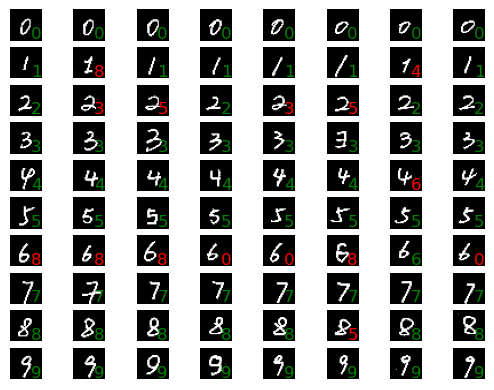

In [89]:
# use the model to predict the handwrite images and plot the prediction results
# put model in evaluation mode and to cpu
model.to('cpu')
model.eval()
with torch.no_grad():
    for i in range(handwrite_test_imgs.shape[0]):
        img = handwrite_test_imgs[i]
        img = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).float()
        output = model(img)
        _, pred = torch.max(output, 1)
        plt.subplot(10, 8, i+1)
        # vertical space between subplots
        # plt.subplots_adjust(hspace=0)
        plt.imshow(handwrite_test_imgs[i], cmap='gray')
        # put the title to the bottom right corner inside the image, use white color
        # shift down the title a little bit
        
        if (int(pred.item()) != math.floor(i/8)):
            plt.title(pred.item(), loc='right', color='red', y=-0.2)
        else:
            plt.title(pred.item(), loc='right', color='green', y=-0.2)
        plt.axis('off')